In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from textblob import TextBlob
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from scipy import stats

sns.set(style='whitegrid', palette='muted', font_scale=1.05)
%matplotlib inline

In [2]:
# 1) Load original dataset

df = pd.read_csv('StudentsPerformance.csv')
print("Original shape:", df.shape)
df.head()

Original shape: (1000, 8)


,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75


In [3]:

print("\nINFO:")
print(df.info())
print("\nMissing values per column:")
print(df.isnull().sum())
print("\nDuplicates count:", df.duplicated().sum())
print("\nBasic statistics:")
print(df.describe(include='all'))

# If duplicates exist
df = df.drop_duplicates()
# If missing values exist - print rows and strategies
if df.isnull().sum().sum() > 0:
    print("\nRows with missing values:")
    print(df[df.isnull().any(axis=1)].head())
    # Strategy (example): drop or impute; here I drop rows with missing for simplicity
    df = df.dropna().reset_index(drop=True)


INFO:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   gender                       1000 non-null   object
 1   race/ethnicity               1000 non-null   object
 2   parental level of education  1000 non-null   object
 3   lunch                        1000 non-null   object
 4   test preparation course      1000 non-null   object
 5   math score                   1000 non-null   int64 
 6   reading score                1000 non-null   int64 
 7   writing score                1000 non-null   int64 
dtypes: int64(3), object(5)
memory usage: 62.6+ KB
None

Missing values per column:
gender                         0
race/ethnicity                 0
parental level of education    0
lunch                          0
test preparation course        0
math score                     0
reading score                  0
wri

In [4]:
# 3) Create engineered features

df['Total_Score'] = df[['math score','reading score','writing score']].sum(axis=1)
df['Avg_Score'] = df['Total_Score'] / 3.0

# Score range and subject-wise z-scores
df['Score_Range'] = df[['math score','reading score','writing score']].max(axis=1) - df[['math score','reading score','writing score']].min(axis=1)
df['Math_z'] = stats.zscore(df['math score'])
df['Reading_z'] = stats.zscore(df['reading score'])
df['Writing_z'] = stats.zscore(df['writing score'])

# Pass count (pass if >= 35) and a simple grade
df['Pass_Count'] = ((df[['math score','reading score','writing score']] >= 35).sum(axis=1)).astype(int)

def perf_level(avg):
    if avg >= 85:
        return 'Excellent'
    elif avg >= 70:
        return 'Good'
    elif avg >= 50:
        return 'Average'
    else:
        return 'Poor'
df['Performance_Level'] = df['Avg_Score'].apply(perf_level)

# Highest and lowest subject
df['High_in'] = df[['math score','reading score','writing score']].idxmax(axis=1)
df['Low_in'] = df[['math score','reading score','writing score']].idxmin(axis=1)

# Percentile rank
df['Percentile'] = df['Total_Score'].rank(pct=True) * 100

In [5]:
feedback_pool = [
    "I enjoyed the classes and felt well prepared for the exam.",
    "I found the exam hard and I was not confident.",
    "The teacher explained concepts clearly, helped me a lot.",
    "I was distracted and couldn't focus during online classes.",
    "Assignments were too many and stressful but helpful.",
    "The practical sessions improved my understanding.",
    "I felt the exam was fair and covered the syllabus.",
    "Poor internet and time management affected my study.",
    "I practiced a lot and felt confident about the questions.",
    "I needed more examples and exercises to practice."
]

np.random.seed(42)
df['Student_Feedback'] = np.random.choice(feedback_pool, size=len(df))

# Text-derived numeric features
df['Feedback_Length'] = df['Student_Feedback'].apply(lambda x: len(str(x).split()))
df['Sentiment'] = df['Student_Feedback'].apply(lambda t: TextBlob(t).sentiment.polarity)

# Confirm we now have many features
print("\nNew shape (after augmentation):", df.shape)
print("Columns:", df.columns.tolist())


New shape (after augmentation): (1000, 22)
Columns: ['gender', 'race/ethnicity', 'parental level of education', 'lunch', 'test preparation course', 'math score', 'reading score', 'writing score', 'Total_Score', 'Avg_Score', 'Score_Range', 'Math_z', 'Reading_z', 'Writing_z', 'Pass_Count', 'Performance_Level', 'High_in', 'Low_in', 'Percentile', 'Student_Feedback', 'Feedback_Length', 'Sentiment']


In [6]:
# 5) Encode categoricals
cat_cols = ['gender','race/ethnicity','parental level of education','lunch','test preparation course','Performance_Level','High_in','Low_in']
le_dict = {}
for col in cat_cols:
    le = LabelEncoder()
    df[col + '_enc'] = le.fit_transform(df[col].astype(str))
    le_dict[col] = le

In [7]:
# 6) Outlier detection / handling (simple winsorization option)

for col in ['math score','reading score','writing score','Total_Score','Avg_Score']:
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    outliers = df[(df[col] < lower) | (df[col] > upper)]
    print(f"{col} outliers count: {len(outliers)}")

num_cols = ['math score','reading score','writing score','Total_Score','Avg_Score','Score_Range','Feedback_Length','Sentiment']
for col in num_cols:
    low = df[col].quantile(0.01)
    high = df[col].quantile(0.99)
    df[col] = np.where(df[col] < low, low, df[col])
    df[col] = np.where(df[col] > high, high, df[col])

math score outliers count: 8
reading score outliers count: 6
writing score outliers count: 5
Total_Score outliers count: 6
Avg_Score outliers count: 6


In [8]:
# 7) Save augmented dataset (so you can upload to GitHub)

df.to_csv('StudentsPerformance_augmented.csv', index=False)
print("Augmented dataset saved to StudentsPerformance_augmented.csv")

Augmented dataset saved to StudentsPerformance_augmented.csv


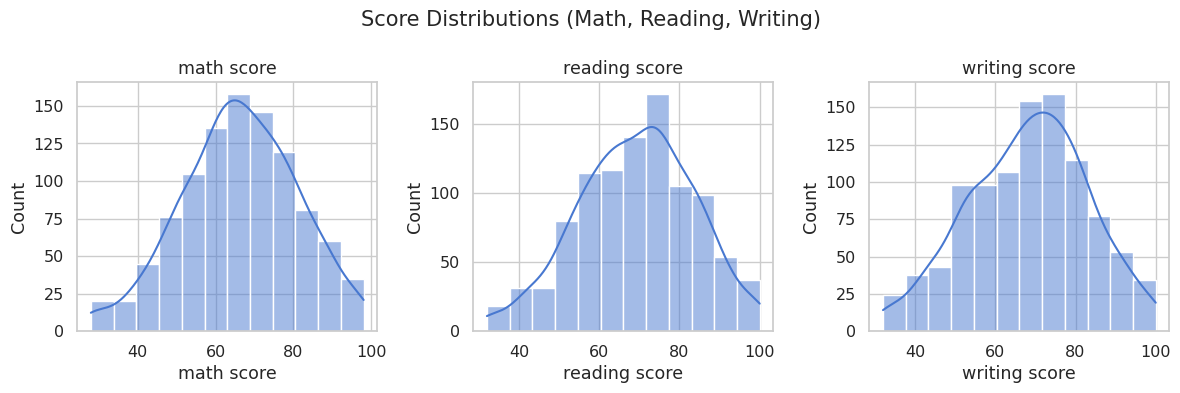

In [10]:
# 1) Distribution plots for each subject (hist + KDE) - shows score spread and skewness
plt.figure(figsize=(12,4))
for i, col in enumerate(['math score','reading score','writing score']):
    plt.subplot(1,3,i+1)
    sns.histplot(df[col], kde=True, bins=12)
    plt.title(col)
plt.suptitle('Score Distributions (Math, Reading, Writing)')
save_fig('score_distributions')
plt.show()

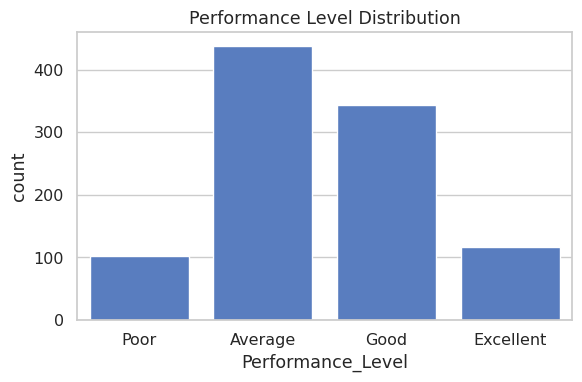

In [14]:
# 5) Countplot: Performance_Level distribution (categorical) - shows how many fall into each level
plt.figure(figsize=(6,4))
sns.countplot(x='Performance_Level', data=df, order=['Poor','Average','Good','Excellent'])
plt.title('Performance Level Distribution')
save_fig('perf_level_count')
plt.show()

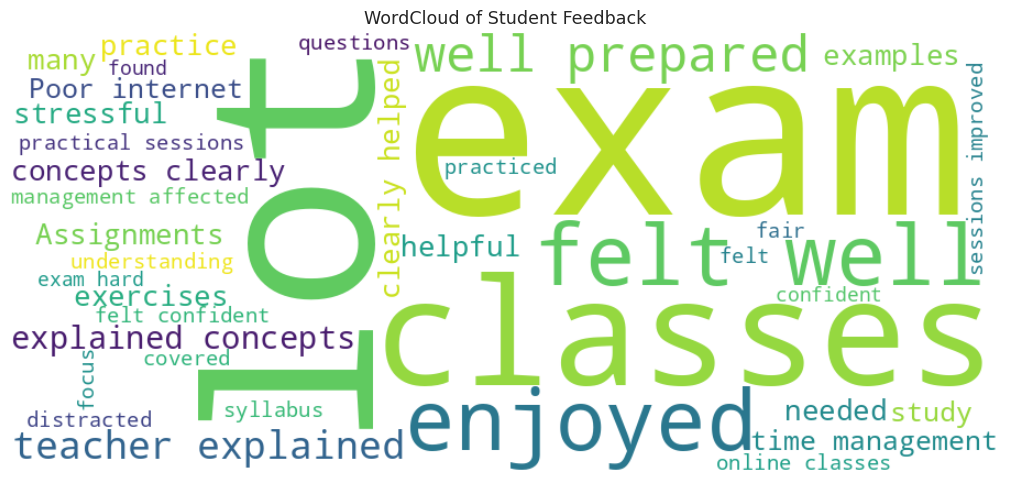

In [15]:
# 6) WordCloud: Student_Feedback - quick view of common feedback words (textual insight)
text = " ".join(df['Student_Feedback'].tolist())
wc = WordCloud(width=900, height=400, background_color='white').generate(text)
plt.figure(figsize=(12,5))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.title('WordCloud of Student Feedback')
save_fig('wordcloud_feedback')
plt.show()

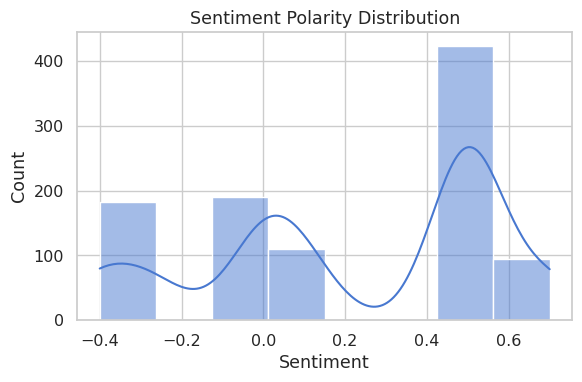

In [16]:
# 7) Sentiment distribution (bar/hist) - shows how feedback sentiment is distributed
plt.figure(figsize=(6,4))
sns.histplot(df['Sentiment'], kde=True, bins=8)
plt.title('Sentiment Polarity Distribution')
save_fig('sentiment_dist')
plt.show()

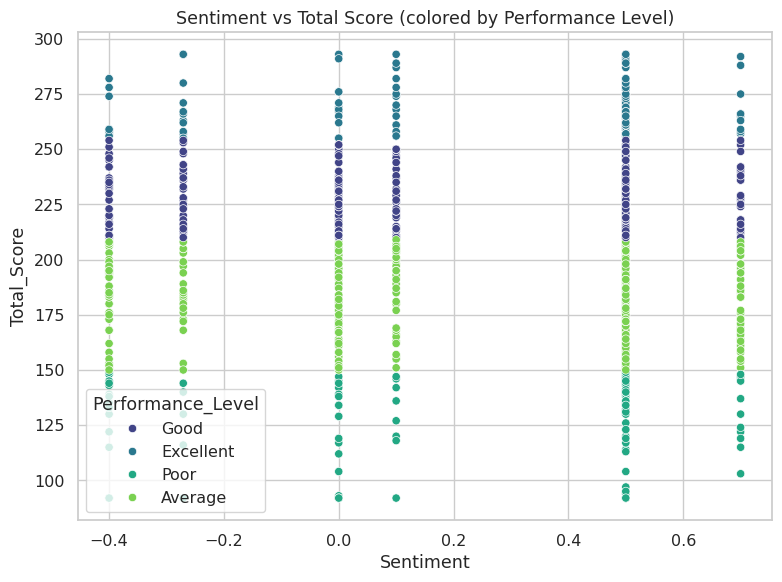

In [28]:
# 8) Scatter: Sentiment vs Total_Score with hue by Performance_Level - shows relation between sentiment and performance
plt.figure(figsize=(8,6))
sns.scatterplot(x='Sentiment', y='Total_Score', hue='Performance_Level', data=df, palette='viridis')
plt.title('Sentiment vs Total Score (colored by Performance Level)')
save_fig('sentiment_vs_total')
plt.show()

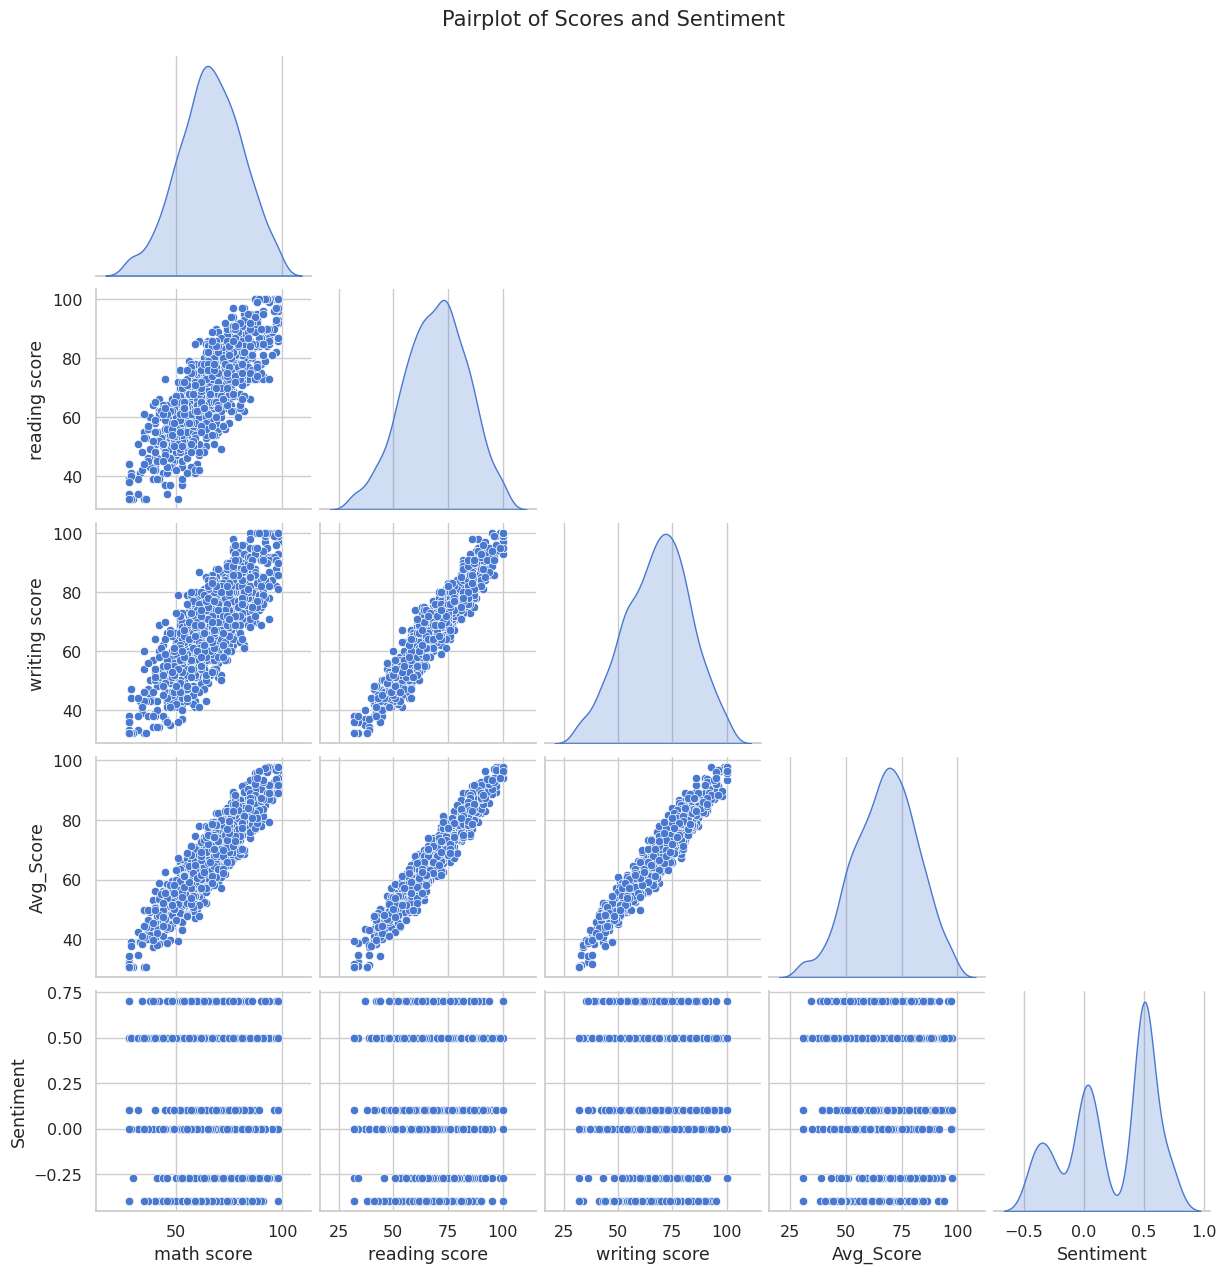

In [18]:
# 9) Pairplot (selected numeric + sentiment) - relationship matrix
sns.pairplot(df[['math score','reading score','writing score','Avg_Score','Sentiment']], diag_kind='kde', corner=True)
plt.suptitle('Pairplot of Scores and Sentiment', y=1.02)
# pairplot saves differently; skip save here
plt.show()

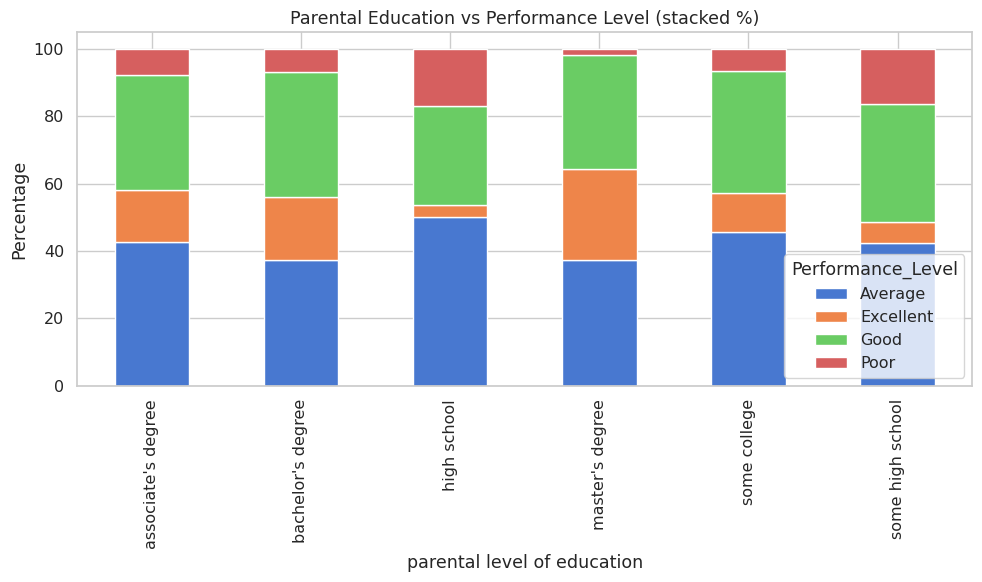

In [19]:
# 10) Stacked bar: parental education vs Performance_Level (percentage) - categorical cross analysis
ct = pd.crosstab(df['parental level of education'], df['Performance_Level'], normalize='index') * 100
ct.plot(kind='bar', stacked=True, figsize=(10,6))
plt.ylabel('Percentage')
plt.title('Parental Education vs Performance Level (stacked %)')
save_fig('parent_edu_vs_perf')
plt.show()

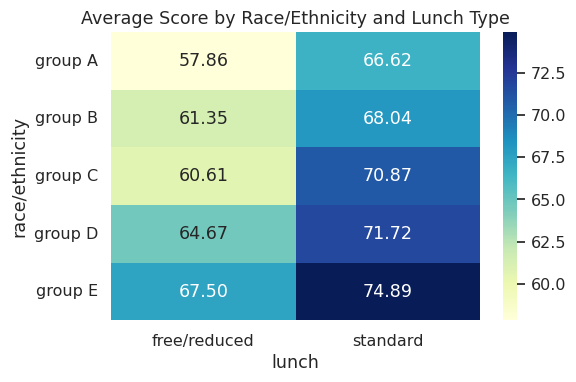

In [20]:
# 11) Heatmap of average scores by race & lunch (pivot) - multi-factor view
pivot = df.pivot_table(values='Avg_Score', index='race/ethnicity', columns='lunch', aggfunc='mean')
plt.figure(figsize=(6,4))
sns.heatmap(pivot, annot=True, fmt='.2f', cmap='YlGnBu')
plt.title('Average Score by Race/Ethnicity and Lunch Type')
save_fig('pivot_race_lunch')
plt.show()

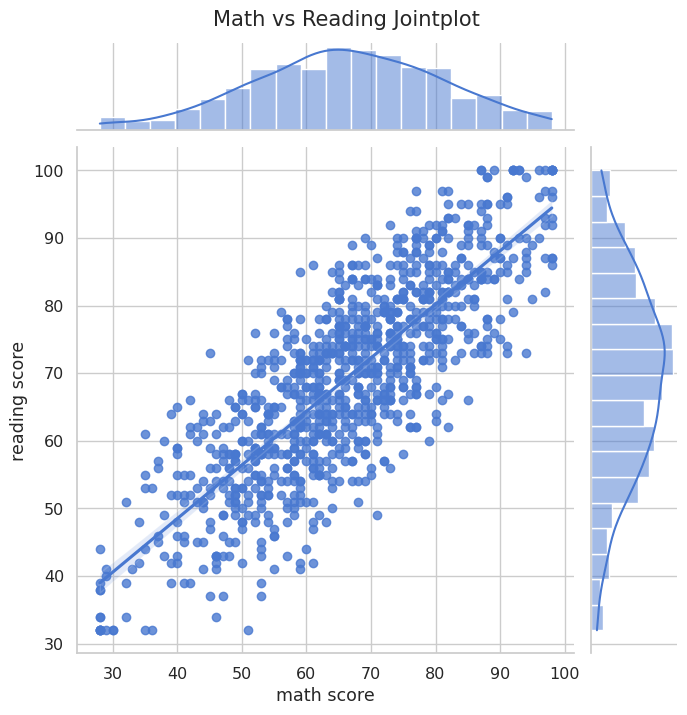

In [21]:
# 12) Jointplot: Math vs Reading with Regression - correlation and density
sns.jointplot(x='math score', y='reading score', data=df, kind='reg', height=7)
plt.suptitle('Math vs Reading Jointplot', y=1.02)

plt.savefig('visuals/math_vs_reading_jointplot.png', dpi=150)
plt.show()

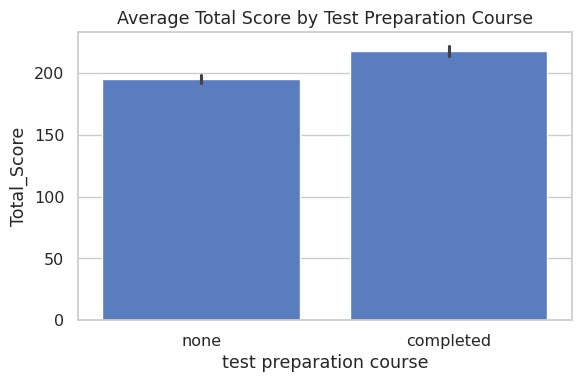

In [22]:
# 13) Barplot: Average Total Score by test preparation course
plt.figure(figsize=(6,4))
sns.barplot(x='test preparation course', y='Total_Score', data=df, estimator=np.mean)
plt.title('Average Total Score by Test Preparation Course')
save_fig('avg_total_by_testprep')
plt.show()

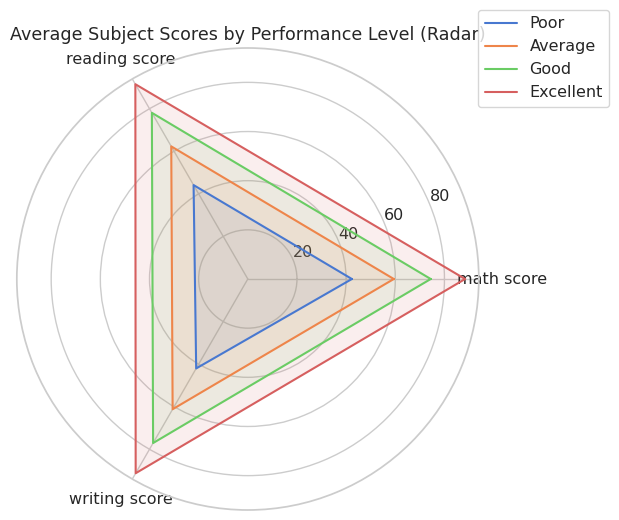

In [23]:
# 14) Radar chart: average subject scores per Performance_Level

groups = df.groupby('Performance_Level')[['math score','reading score','writing score']].mean().reindex(['Poor','Average','Good','Excellent'])
labels = groups.columns.tolist()
import math
angles = np.linspace(0, 2 * math.pi, len(labels), endpoint=False).tolist()

angles += angles[:1]
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, polar=True)
for idx, row in groups.iterrows():
    values = row.tolist()
    values += values[:1]
    ax.plot(angles, values, label=idx)
    ax.fill(angles, values, alpha=0.1)
ax.set_thetagrids(np.degrees(angles[:-1]), labels)
plt.title('Average Subject Scores by Performance Level (Radar)')
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
plt.savefig('visuals/radar_perf_levels.png', dpi=150)
plt.show()

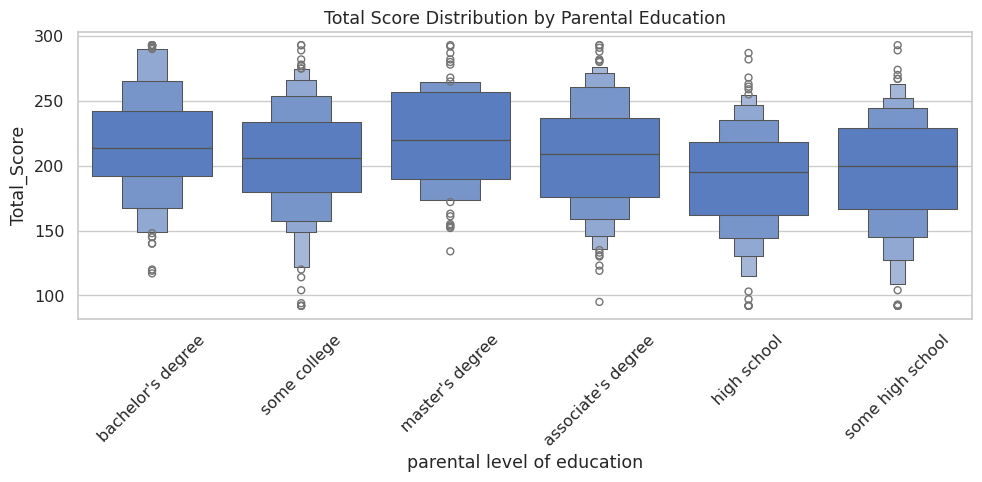

In [24]:
# 15) Boxen plot: Total_Score by parental level of education - shows distribution differences
plt.figure(figsize=(10,5))
sns.boxenplot(x='parental level of education', y='Total_Score', data=df, order=df['parental level of education'].unique())
plt.xticks(rotation=45)
plt.title('Total Score Distribution by Parental Education')
save_fig('boxen_parentedu_total')
plt.show()

In [29]:
# 9) Scaling and preparing for modeling
model_cols = ['math score','reading score','writing score','Sentiment','Feedback_Length','Score_Range','Percentile']
X = df[model_cols]
y = (df['Avg_Score'] >= df['Avg_Score'].quantile(0.75)).astype(int)  # example: top-quartile performer

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
print("Model-ready shapes:", X_train.shape, X_test.shape)

Model-ready shapes: (800, 7) (200, 7)


In [30]:
# STEP 10: Deep Learning Model (MLP)

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

# Using the same prepared features from earlier
# X_scaled, y, X_train, X_test, y_train, y_test should already exist

# Define MLP architecture
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Early stopping for safety
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train model
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=16,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.5839 - loss: 0.6675 - val_accuracy: 0.8850 - val_loss: 0.4233
Epoch 2/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8950 - loss: 0.3774 - val_accuracy: 0.9150 - val_loss: 0.2461
Epoch 3/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9163 - loss: 0.2372 - val_accuracy: 0.9400 - val_loss: 0.1740
Epoch 4/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9409 - loss: 0.1619 - val_accuracy: 0.9400 - val_loss: 0.1435
Epoch 5/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9434 - loss: 0.1364 - val_accuracy: 0.9400 - val_loss: 0.1268
Epoch 6/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9521 - loss: 0.1138 - val_accuracy: 0.9400 - val_loss: 0.1212
Epoch 7/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9462 - loss: 0.1085 - val_accuracy: 0.9400 - val_loss: 0.1165
Epoch 8/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9706 - loss: 0.0836 - val_accuracy: 0.9450 - val_loss: 0.1100
Epo

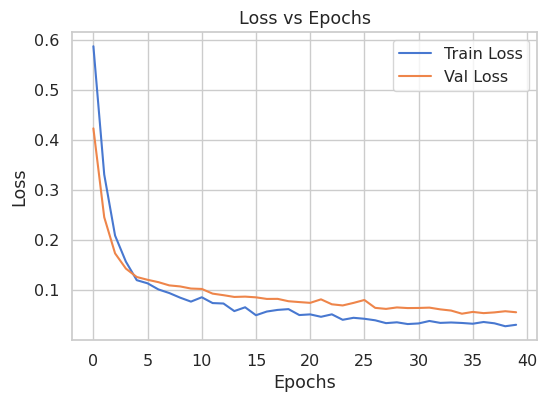

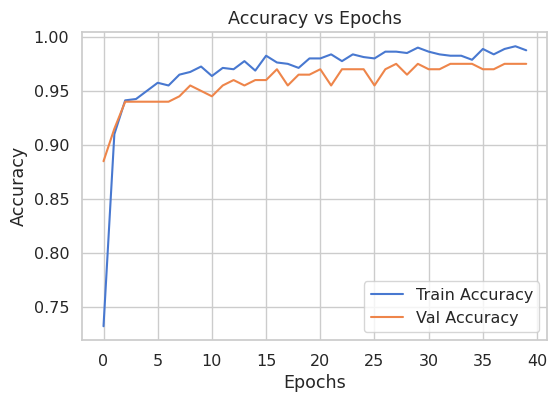

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


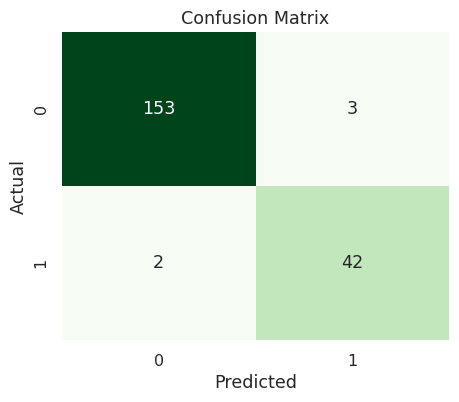

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


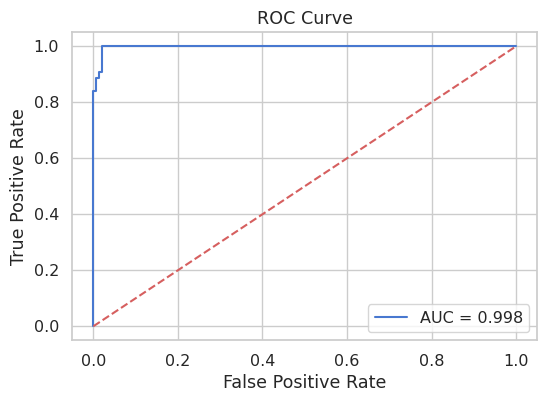

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.98       156
           1       0.93      0.95      0.94        44

    accuracy                           0.97       200
   macro avg       0.96      0.97      0.96       200
weighted avg       0.98      0.97      0.98       200



In [31]:
# STEP 11: Model Evaluation Visualization

# 1️⃣ Loss vs Epoch
plt.figure(figsize=(6,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 2️⃣ Accuracy vs Epoch
plt.figure(figsize=(6,4))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# 3️⃣ Confusion Matrix
y_pred = (model.predict(X_test) > 0.5).astype(int)
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# 4️⃣ ROC Curve and AUC
fpr, tpr, _ = roc_curve(y_test, model.predict(X_test))
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1],[0,1],'r--')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

# 5️⃣ Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred))
